E:\UNI\D_Drive\PhD\Year_1\2021_02_05_OwnOEDmcPaper\Scripts\PLac

# Import all packages

In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
using Turing
using MCMCChains
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using OrdinaryDiffEq
Random.seed!(145975);
using CmdStan
using KernelDensity
using LaTeXStrings
using StatsBase
using JLD2
using BlackBoxOptim
using BlackBoxOptim: num_func_evals
using HypothesisTests
using BayesianOptimization, GaussianProcesses

set_cmdstan_home!("C:\\cmdstan\\cmdstan-2.30.0");

┌ Warning: Environment variable CMDSTAN_HOME not set. Use set_cmdstan_home!.
└ @ CmdStan C:\Users\dgomez\.julia\packages\CmdStan\2vwWj\src\CmdStan.jl:27


In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\FunctionsBayesInfs.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\FunctionsBayesOED.jl")

redSamples (generic function with 2 methods)

# Define True Theta and Bounds

In [3]:
trueP = [48.0, 55.0,0.005911,0.01832,0.042171,0.5365,0.98047,0.991257,0.93335,0.008241,0.9943848,0.001974,   15];

bounds = [[48, 55, 0.001, 0.005, 0.042171, 0.5365, 0.98047, 0.991257, 0.93335, 0.008241, 0.7, 0.0008, 15],
          [48, 55, 0.01, 0.05, 0.042171, 0.5365, 0.98047, 0.991257, 0.93335, 0.008241, 1.2, 0.005, 15]];


InitsY0 = [450, 12599, 226];

boundY0 = [[450, 12599, 226],
           [450, 12599, 226]];

# Perform OEDmc

## Get Prior Samples

In [ ]:
# priorTheta[1] = Normal(40.92, 10); priorTheta[2] = Normal(51.23, 10); priorTheta[3] = Uniform(0.001, 0.01); priorTheta[4] = Uniform(0.005, 0.05); priorTheta[5] = Uniform(0.01, 0.08);
# priorTheta[6] = Uniform(0.1, 0.8); priorTheta[7] = Uniform(0.7, 1.2); priorTheta[8] = Uniform(0.7, 1.2); priorTheta[9] = Uniform(0.7, 1.2); priorTheta[10] = Uniform(0.005, 0.012);
# priorTheta[11] = Uniform(0.7, 1.2); priorTheta[12] = Uniform(0.0008, 0.005); priorTheta[13] = Normal(18.5, 2.29);

# priotY0[1] = Uniform(300, 1000); priotY0[2] = Uniform(7000, 25000); priotY0[3] = Uniform(100, 1000);

In [4]:
NSamps = 1000;

priorTheta = Array{Any}(undef, 13);
priotY0 = Array{Any}(undef, 3);

priorTheta[1] = Normal(40.92, 10); priorTheta[2] = Normal(51.23, 10); priorTheta[3] = Truncated(Normal(0.0055, 0.00275), 0,2); priorTheta[4] = Truncated(Normal(0.0275, 0.01375), 0,2); 
priorTheta[5] = Truncated(Normal(0.045, 0.0225), 0,2); priorTheta[6] = Truncated(Normal(0.45, 0.225), 0,2); priorTheta[7] = Truncated(Normal(0.95, 0.475), 0,2); 
priorTheta[8] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[9] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[10] = Truncated(Normal(0.0085, 0.00425), 0,2);
priorTheta[11] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[12] = Truncated(Normal(0.0029, 0.00145), 0,2); priorTheta[13] = Normal(18.5, 2.29);

priotY0[1] = Truncated(Normal(650, 260), 0, 1600); priotY0[2] = Truncated(Normal(16000, 6400), 0, 4e4); priotY0[3] = Truncated(Normal(550, 275), 0, 1600);
global sampsTh = zeros(NSamps, 13);
global sampsY0 = zeros(NSamps, 3);

Random.seed!(687865443); 

for i in 1:13
    sampsTh[:,i] = rand(priorTheta[i], NSamps);
end
for i in 1:3
    sampsY0[:,i] = rand(priotY0[i], NSamps);
end
sampsTh[:,1] .= trueP[1];
sampsTh[:,2] .= trueP[2];
sampsTh[:,5] .= trueP[5];
sampsTh[:,6] .= trueP[6];
sampsTh[:,7] .= trueP[7];
sampsTh[:,8] .= trueP[8];
sampsTh[:,9] .= trueP[9];
sampsTh[:,10] .= trueP[10];
sampsTh[:,13] .= trueP[13];

sampsY0[:,1] .= InitsY0[1];
sampsY0[:,2] .= InitsY0[2];
sampsY0[:,3] .= InitsY0[3];


In [5]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global tsC2 = dat32mM[:,1]
global ts = 0:tsC2[end];
global samps = convert.(Int, tsC2);


In [6]:
CompRepUtil_Entro_OEDmc([15.0125])

207.57513735850148

## Optimisation 

In [7]:
steps = 1;

In [8]:
model = ElasticGPE(steps,                            # 4*2 input dimensions
           mean = MeanConst(0.),
           kernel = SEArd(zeros(steps), 3.),
           logNoise = 0.,
           capacity = 3000);

In [9]:
modeloptimizer = MAPGPOptimizer(every = 50, noisebounds = [-4, 3],       # bounds of the logNoise
                               kernbounds = [[-1*ones(steps); 0], [4*ones(steps); 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                               maxeval = 50);

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = #MAPGPOptimizer#19 at gp.jl:37 [inlined]
└ @ Core C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\models\gp.jl:37


In [10]:
opt = BOpt(CompRepUtil_Entro_OEDmc,
          model,
          ExpectedImprovement(),                   # type of acquisition            UpperConfidenceBound
          modeloptimizer,
          [0.1],[40.], # lowerbounds, upperbounds
          repetitions = 1,                          # evaluate the function for each input 1 times
          maxiterations = 200,                      # evaluate at 50 input positions
          sense = Max,  
                                      # maximise the function
          acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                restarts = 2,       # run the NLopt method from 5 random initial conditions each time.
                maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl
          verbosity = Progress);

In [14]:
result = boptimize!(opt)

┌ Info: 2024-08-07T18:33:59.401	iteration: 5	current optimum: 240.77015002983927
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-07T18:34:07.795	iteration: 6	current optimum: 240.77015002983927
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-07T18:34:12.166	iteration: 7	current optimum: 243.31789042638005
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-07T18:34:16.447	iteration: 8	current optimum: 243.31789042638005
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-07T18:34:20.820	iteration: 9	current optimum: 243.31789042638005
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08

(observed_optimum = 337.3199836533089, observed_optimizer = [0.6359901007762568], model_optimum = 333.9131762525552, model_optimizer = [0.618179735573832])

In [15]:
inputOED = result.observed_optimizer

1-element Vector{Float64}:
 0.6359901007762568

In [11]:
inputOED = 0.6359901007762568;

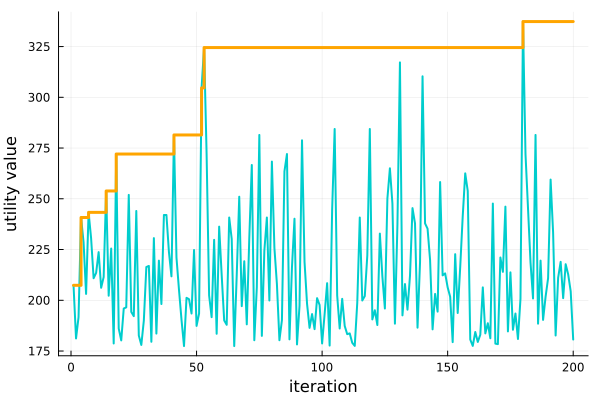

In [16]:
utilb = zeros(length(opt.model.y));
utilb[1] = opt.model.y[1];
for i in 2:length(opt.model.y)
    if opt.model.y[i]>=utilb[i-1]
        utilb[i] = opt.model.y[i];
    else
        utilb[i] = utilb[i-1];
    end
end

plot(opt.model.y, label = "", xlabel = "iteration", ylabel = "utility value", color="cyan3", linewidth = 2)
plot!(1:length(utilb), utilb, label = "", linetype=:step, color="orange", linewidth = 3)

### Save resutls

In [17]:
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED1_OEDmc.jld"), "result", result, "inputOED",inputOED)

In [18]:
optres = Dict("acquisitionoptions"=>opt.acquisitionoptions,
                "duration"=>opt.duration,
#                 "func"=>opt.func,
#                 "initializer"=>opt.initializer,
#                 "iterations"=>opt.iterations,
#                 "iterations"=>opt.iterations,
#                 "lowerbounds"=>opt.lowerbounds,
#                 "model"=>opt.model,
                "model_optimizer"=>opt.model_optimizer,
                "model_optimum"=>opt.model_optimum,
                "modeloptimizer"=>opt.modeloptimizer,
                "observed_optimizer"=>opt.observed_optimizer,
                "observed_optimum"=>opt.observed_optimum,
#                 "opt"=>opt.opt,
                "repetitions"=>opt.repetitions,
                "sense"=>opt.sense,
#                 "timeroutput"=>opt.timeroutput,
                "upperbounds"=>opt.upperbounds,
#                 "verbosity"=>opt.verbosity,
                "modelX"=>Array(opt.model.x),
                "modelY"=>Array(opt.model.y));
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED1_OEDmc2.jld"), optres)

## Generate Pseudo-Data

In [45]:
Nexp = 1;

ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(trueP[end]*0.12)]

SimulsAll = Array{Any}(undef, Nexp,3);
for i in 1:Nexp
    SimulsAll[i,1], SimulsAll[i,2], SimulsAll[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
end
ObsS = Array{Any}(undef, Nexp,2);
for i in 1:Nexp
    ObsS[i,1] = SimulsAll[i,1][:,14,1]; # Pyruvate HP
    ObsS[i,2] = SimulsAll[i,1][:,13,1]; # Lactate HP
end

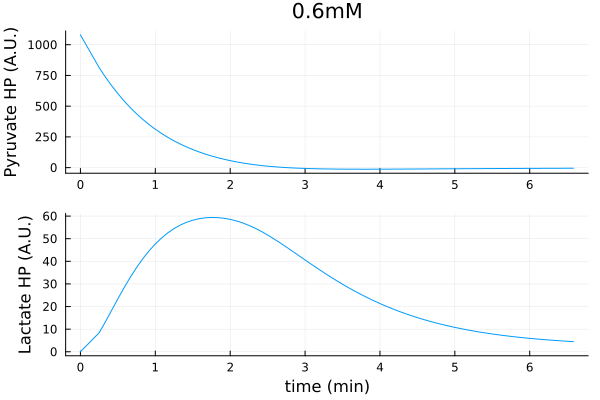

In [46]:
pp1 = plot(samps./60, ObsS[1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, ObsS[1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

In [47]:
sigm1=0.12; # 10% additive heteroscedastic noise
sigm2=0.075;


Random.seed!(45659211); 

SolN1NoiseHet = zeros(length(samps),Nexp,2);
basemat = zeros(length(samps),Nexp,2);

i = 1

for i in 1:Nexp
    basemat[:,i,1] = ObsS[i,1]'.*sigm1; # introduce new diagonal matrices
    basemat[:,i,2] = ObsS[i,2]'.*sigm2;

    for zer in collect(1:length(samps)) # To avoid having standard deviations of 0
        if basemat[zer,i,1]<=1
            basemat[zer,i,1] = 1;
        end
        if basemat[zer,i,2]<=1
            basemat[zer,i,2] = 1;
        end
    end

    SolN1NoiseHet[:,i, 1] = ObsS[i,1]#+rand(MvNormal(zeros(length(samps)),basemat[:,i,1]));
    SolN1NoiseHet[:,i, 2] = ObsS[i,2]+rand(MvNormal(zeros(length(samps)),basemat[:,i,2]));
    SolN1NoiseHet[1,i, 2] = 0;
end

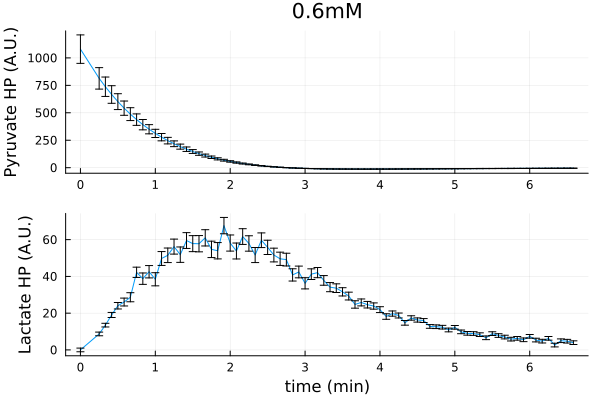

In [48]:
pp1 = plot(samps./60, SolN1NoiseHet[:,1, 1], yerror = basemat[:,1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, SolN1NoiseHet[:,1, 2], yerror = basemat[:,1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

## Generate CSV Files For PseudoData

In [49]:
# Observables
for i in 1:Nexp
    Observables = zeros(length(samps),5);
    Observables[:,1] = samps;
    Observables[:,2] = SolN1NoiseHet[:,i, 1];
    Observables[:,3] = basemat[:,i, 1];
    Observables[:,4] = SolN1NoiseHet[:,i, 2];
    Observables[:,5] = basemat[:,i, 2];
    obs_head = ["time","Pyr_MEAN","Pyr_STD","Lac_MEAN","Lac_STD"];

    df1 = DataFrame(Observables, :auto);
    rename!(df1, [obs_head[i] for i in 1:5]);
    CSV.write(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\CompReprFixedPars_OED1_Observables_Pyr",string(round(inputOED[1], digits = 1)),"mM.csv"), df1);
end

# Bayesian Inference 1

## Extract Data

In [12]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 1;
paths = [mainpath*"CompReprFixedPars_OED1_Observables_Pyr"*string(round(inputOED[1], digits = 1))*"mM.csv"]

1-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED1_Observables_Pyr0.6mM.csv"

In [13]:
Random.seed!(8987654);
global dat = restructDatInfCompRep_FixedSF(paths, InitsY0[1], InitsY0[2], InitsY0[3], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [1080.0; 813.677; … ; -5.10294; -4.95521;;; 0.0; 8.69903; … ; 4.7…
  "stsl"   => [78;;]
  "obSta"  => [1 2]
  "sts"    => [0; 15; … ; 390; 395;;]
  "obser"  => 2
  "Y0us"   => [600.0; 0.0; … ; 0.0; 1080.0;;]
  "ts"     => [1.0e-20; 1.0; … ; 394.0; 395.0;;]
  "itp"    => [0.0]
  "ncells" => [0;;]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [129.6; 97.6413; … ; 1.0; 1.0;;; 1.0; 1.0; … ; 1.0; 1.0]
  "m"      => 1
  "nts"    => [395;;]

## Prior Prediction

In [14]:
priorTheta = Array{Any}(undef, 13);
priotY0 = Array{Any}(undef, 3);

priotY0[1] = Truncated(Normal(650, 260), 0, 1500);
priotY0[2] = Truncated(Normal(16000, 6400), 0, 4e4);
priotY0[3] = Truncated(Normal(550, 275), 0, 2000);

priorTheta[1] = Normal(40.92, 10); priorTheta[2] = Normal(51.23, 10); priorTheta[3] = Truncated(Normal(0.0055, 0.00275), 0,2); priorTheta[4] = Truncated(Normal(0.0275, 0.01375), 0,2); 
priorTheta[5] = Truncated(Normal(0.045, 0.0225), 0,2); priorTheta[6] = Truncated(Normal(0.45, 0.225), 0,2); priorTheta[7] = Truncated(Normal(0.95, 0.475), 0,2); 
priorTheta[8] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[9] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[10] = Truncated(Normal(0.0085, 0.00425), 0,2);
priorTheta[11] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[12] = Truncated(Normal(0.0029, 0.00145), 0,2); priorTheta[13] = Normal(18.5, 2.29);

In [15]:
sampsTh = zeros(8000, 13);
sampsY0 = zeros(8000, 3);

Random.seed!(657986354); 

for i in 1:13
    sampsTh[:,i] = rand(priorTheta[i], 8000);
end
for i in 1:3
    sampsY0[:,i] = rand(priotY0[i], 8000);
end

In [16]:
sampsTh[:,1] .= trueP[1];
sampsTh[:,2] .= trueP[2];
sampsTh[:,5] .= trueP[5];
sampsTh[:,6] .= trueP[6];
sampsTh[:,7] .= trueP[7];
sampsTh[:,8] .= trueP[8];
sampsTh[:,9] .= trueP[9];
sampsTh[:,10] .= trueP[10];
sampsTh[:,13] .= trueP[13];

sampsY0[:,1] .= InitsY0[1];
sampsY0[:,2] .= InitsY0[2];
sampsY0[:,3] .= InitsY0[3];

In [58]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, sampsY0[i,1], sampsY0[i,1], sampsY0[i,1], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(sampsTh[i,end]*0.12)];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(sampsTh[i,1:end], 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [59]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


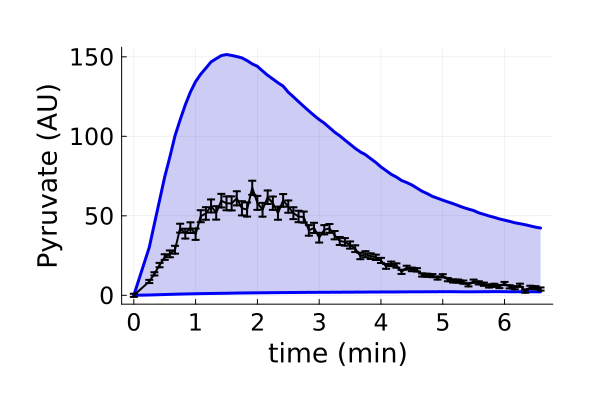

In [60]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")

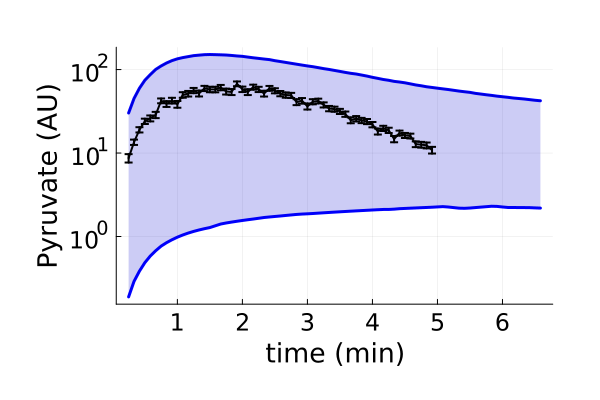

In [61]:
pr = plot(tsC2[2:end]./60, PriorQuant[1][2:end], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2[2:end]./60, PriorQuant[2][2:end], label = "", color = "blue", linewidth = 3)
  plot!(tsC2[2:end]./60, PriorQuant[1][2:end], fillrange=PriorQuant[2][2:end], label="", color="blue3", fillalpha=0.2, yaxis=:log)

  plot!(dat["sts"][2:end-20]./60, dat["Means"][:,1,2][2:end-20], yerror = dat["Erros"][:,1,2][2:end-20], linewidth = 2, colour = "black", label = "", yaxis=:log)

  
display(pr)

## MLE to obtain a good first guess for inference

In [17]:
function ObjectFunctMECp_MLE(p)

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p[1:end-3], 0);

    # Define time vector
    t2cor = dat["sts"];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat["Means"][1,1,1]/(ScFm*0.12), 0, dat["Means"][1,1,2]/(ScFm*0.12), p[end-2], p[end-1], p[end], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(ScFm*0.12), dat["Means"][1,1,2], dat["Means"][1,1,1]];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);

    # Simulate
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllCp(ts1, pD2, ivss1, samps1);
    
    mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat["Erros"][:,1,2].^2) .+ ((SimOnTime1[:,13] .- dat["Means"][:,1,2]).^2)./(dat["Erros"][:,1,2].^2)));

    # obj = (mm21+mm22)*(mm11+mm12);
    if p[end-2] >= p[end-1]
        mm22 = mm22*10;
    end
    obj = -(mm22);

    
    return(obj)

end


ObjectFunctMECp_MLE (generic function with 1 method)

In [18]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_MLE(p)

3874.7835505421626

In [19]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [65]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_MLE; SearchRange = vcat([(bounds[1][i], bounds[2][i]) for i in 1:13], [(boundY0[1][i], boundY0[2][i]) for i in 1:3]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*1, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 160 evals, 91 steps, improv/step: 0.319 (last = 0.3187), fitness=224.595991140
1.02 secs, 316 evals, 213 steps, improv/step: 0.286 (last = 0.2623), fitness=215.215506647
1.54 secs, 478 evals, 371 steps, improv/step: 0.294 (last = 0.3038), fitness=194.122339218
2.04 secs, 658 evals, 577 steps, improv/step: 0.253 (last = 0.1796), fitness=180.523412414
2.54 secs, 826 evals, 766 steps, improv/step: 0.244 (last = 0.2169), fitness=176.854819856
3.04 secs, 992 evals, 962 steps, improv/step: 0.242 (last = 0.2347), fitness=158.830879281
3.54 secs, 1160 evals, 1156 steps, improv/step: 0.243 (last = 0.2474), fitness=158.830879281
4.04 secs, 1328 evals, 1349 steps, improv/step: 0.231 (last = 0.1554), fitness=158.830879281
4.55 secs, 1489 evals, 1550 steps, improv/step: 0.217 (last = 0.1

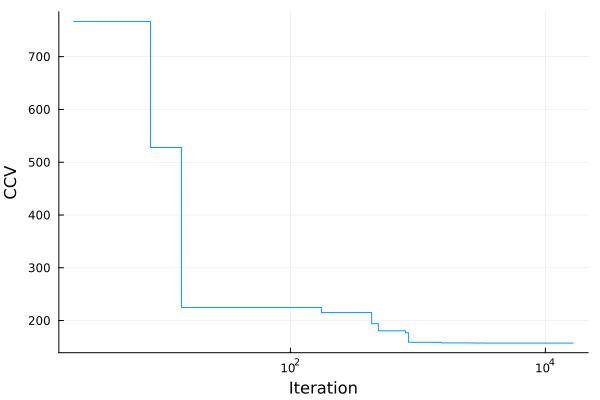

In [66]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [67]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.005613379864338254
     0.019395115519811136
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     1.0308136659245337
     0.0017622656782447976
    15.0
   450.0
 12599.0
   226.0

In [69]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_OED1.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED1.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [20]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED1.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.005613379864338254
     0.019395115519811136
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     1.0308136659245337
     0.0017622656782447976
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [21]:
preTrans = zeros(13);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [22]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.041229041577546914, "kr" => -0.784644359831174, "ki" => 0.17013403352533424, "kpl" => -0.5894461440137355)
 Dict("kin" => 0.041229041577546914, "kr" => -0.784644359831174, "ki" => 0.17013403352533424, "kpl" => -0.5894461440137355)
 Dict("kin" => 0.041229041577546914, "kr" => -0.784644359831174, "ki" => 0.17013403352533424, "kpl" => -0.5894461440137355)
 Dict("kin" => 0.041229041577546914, "kr" => -0.784644359831174, "ki" => 0.17013403352533424, "kpl" => -0.5894461440137355)

In [23]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.041229
  "kr"  => -0.784644
  "ki"  => 0.170134
  "kpl" => -0.589446

## Inference

In [75]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_OED1_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;

In [76]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_OED1_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one interna

Inference for Stan model: PyrCompReprFP_OED1_Try1_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(1000,1000,1000,1000); thin=(1,1,1,1); 12000 iterations saved.

Warmup took (13181, 12184, 13898, 15052) seconds, 15 hours total
Sampling took (28722, 27504, 30724, 22219) seconds, 30 hours total

                    Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__            -1.6e+02  2.9e-02  1.4e+00  -1.6e+02  -1.6e+02  -1.6e+02  2.3e+03  2.1e-02  1.0e+00
accept_stat__       0.95  1.1e-02    0.091      0.78      0.99      1.00  6.6e+01  6.0e-04  1.0e+00
stepsize__         0.055  7.4e-03    0.019     0.028     0.053     0.090  6.5e+00  6.0e-05  1.2e+00
treedepth__          4.6  6.0e-02      1.3       2.0       5.0       6.0  4.7e+02  4.3e-03  1.0e+00
n_leapfrog__          49  2.6e+00       40       7.0        39       127  2.3e+02  2.1e-03  1.0e+00
divergent__         0.00      nan     0.00      0.00      0.00      0.00      nan      nan 

(0, [-158.165 0.990381 … 12599.0 226.0; -158.165 0.0 … 12599.0 226.0; … ; -160.845 0.925898 … 12599.0 226.0; -157.941 0.98643 … 12599.0 226.0;;; -158.443 0.974335 … 12599.0 226.0; -158.443 0.0 … 12599.0 226.0; … ; -163.449 0.961277 … 12599.0 226.0; -166.334 0.866978 … 12599.0 226.0;;; -157.847 0.0820837 … 12599.0 226.0; -157.847 2.20981e-204 … 12599.0 226.0; … ; -160.541 0.996823 … 12599.0 226.0; -160.445 0.999979 … 12599.0 226.0;;; -160.632 0.847113 … 12599.0 226.0; -160.632 0.0 … 12599.0 226.0; … ; -158.79 0.739688 … 12599.0 226.0; -159.512 0.988371 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [77]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionFixedParsInferRes_OED1_Try2.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [78]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.csv"

In [24]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00546951  0.0216125  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.0056332   0.0202815  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00564036  0.0199952  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.005646    0.0201812  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00525309  0.0232709  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.0052957   0.023214   0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00608228  0.0174332  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00609976  0.017941   0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00575332  0.0191809  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00578414  0.0178741  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00555723  0.0212003  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00547432  0.020486   0.042171     15.0

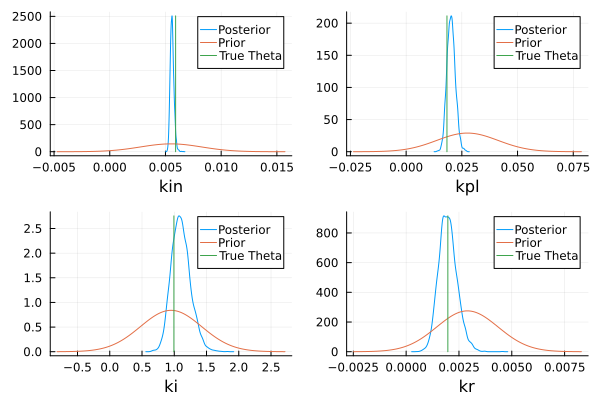

In [25]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [81]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,1,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [82]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


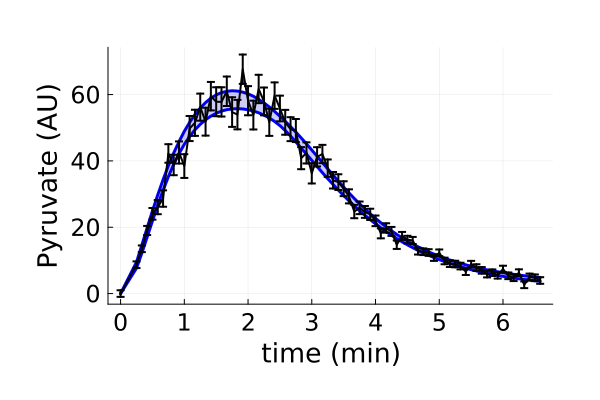

In [83]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")

# Perform OEDmc 2

In [26]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global tsC2 = dat32mM[:,1]
global ts = 0:tsC2[end];
global samps = convert.(Int, tsC2);


In [27]:
global sampsTh = abs.(poster[:,1:13]);
global sampsY0 = abs.(poster[:,14:end]);

In [28]:
CompRepUtil_Entro_OEDmc([0.1])

-9.799653210479788

## Optimisation 

In [29]:
steps = 1;

In [30]:
model = ElasticGPE(steps,                            # 4*2 input dimensions
           mean = MeanConst(0.),
           kernel = SEArd(zeros(steps), 3.),
           logNoise = 0.,
           capacity = 3000);

In [31]:
modeloptimizer = MAPGPOptimizer(every = 50, noisebounds = [-4, 3],       # bounds of the logNoise
                               kernbounds = [[-1*ones(steps); 0], [4*ones(steps); 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                               maxeval = 50);

In [32]:
opt = BOpt(CompRepUtil_Entro_OEDmc,
          model,
          ExpectedImprovement(),                   # type of acquisition            UpperConfidenceBound
          modeloptimizer,
          [0.1],[40.], # lowerbounds, upperbounds
          repetitions = 1,                          # evaluate the function for each input 1 times
          maxiterations = 300,                      # evaluate at 50 input positions
          sense = Max,  
                                      # maximise the function
          acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                restarts = 2,       # run the NLopt method from 5 random initial conditions each time.
                maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl
          verbosity = Progress);

In [91]:
result = boptimize!(opt) # 40 min

┌ Info: 2024-08-13T07:42:58.568	iteration: 5	current optimum: 101.97764839302127
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-13T07:43:08.908	iteration: 6	current optimum: 101.97764839302127
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-13T07:43:14.288	iteration: 7	current optimum: 101.97764839302127
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-13T07:43:19.082	iteration: 8	current optimum: 101.97764839302127
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-13T07:43:21.076	iteration: 9	current optimum: 101.97764839302127
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08

(observed_optimum = 111.49270747921011, observed_optimizer = [2.2545101343712663], model_optimum = 112.1193331156961, model_optimizer = [2.2783140304814666])

In [92]:
inputOED = result.observed_optimizer

1-element Vector{Float64}:
 2.2545101343712663

In [33]:
inputOED = 2.2545101343712663;

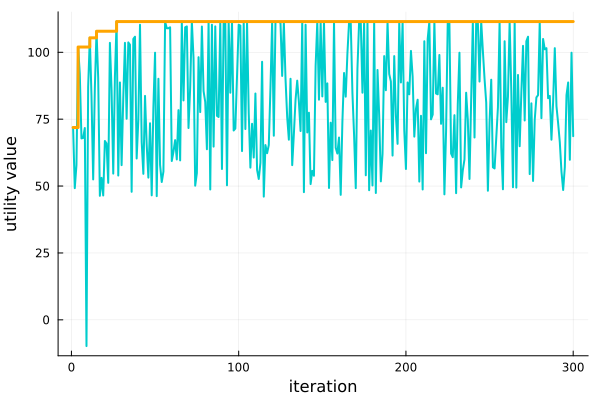

In [93]:
utilb = zeros(length(opt.model.y));
utilb[1] = opt.model.y[1];
for i in 2:length(opt.model.y)
    if opt.model.y[i]>=utilb[i-1]
        utilb[i] = opt.model.y[i];
    else
        utilb[i] = utilb[i-1];
    end
end

plot(opt.model.y, label = "", xlabel = "iteration", ylabel = "utility value", color="cyan3", linewidth = 2)
plot!(1:length(utilb), utilb, label = "", linetype=:step, color="orange", linewidth = 3)

### Save resutls

In [94]:
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED2_OEDmc.jld"), "result", result, "inputOED",inputOED)

In [95]:
optres = Dict("acquisitionoptions"=>opt.acquisitionoptions,
                "duration"=>opt.duration,
#                 "func"=>opt.func,
#                 "initializer"=>opt.initializer,
#                 "iterations"=>opt.iterations,
#                 "iterations"=>opt.iterations,
#                 "lowerbounds"=>opt.lowerbounds,
#                 "model"=>opt.model,
                "model_optimizer"=>opt.model_optimizer,
                "model_optimum"=>opt.model_optimum,
                "modeloptimizer"=>opt.modeloptimizer,
                "observed_optimizer"=>opt.observed_optimizer,
                "observed_optimum"=>opt.observed_optimum,
#                 "opt"=>opt.opt,
                "repetitions"=>opt.repetitions,
                "sense"=>opt.sense,
#                 "timeroutput"=>opt.timeroutput,
                "upperbounds"=>opt.upperbounds,
#                 "verbosity"=>opt.verbosity,
                "modelX"=>Array(opt.model.x),
                "modelY"=>Array(opt.model.y));
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED2_OEDmc2.jld"), optres)

## Generate Pseudo-Data

In [96]:
Nexp = 1;

ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(trueP[end]*0.12)]

SimulsAll = Array{Any}(undef, Nexp,3);
for i in 1:Nexp
    SimulsAll[i,1], SimulsAll[i,2], SimulsAll[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
end
ObsS = Array{Any}(undef, Nexp,2);
for i in 1:Nexp
    ObsS[i,1] = SimulsAll[i,1][:,14,1]; # Pyruvate HP
    ObsS[i,2] = SimulsAll[i,1][:,13,1]; # Lactate HP
end

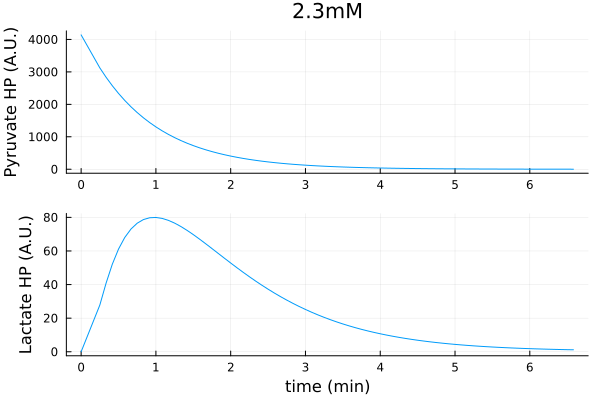

In [97]:
pp1 = plot(samps./60, ObsS[1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, ObsS[1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

In [98]:
sigm1=0.12; # 10% additive heteroscedastic noise
sigm2=0.075;


Random.seed!(45659211); 

SolN1NoiseHet = zeros(length(samps),Nexp,2);
basemat = zeros(length(samps),Nexp,2);

i = 1

for i in 1:Nexp
    basemat[:,i,1] = ObsS[i,1]'.*sigm1; # introduce new diagonal matrices
    basemat[:,i,2] = ObsS[i,2]'.*sigm2;

    for zer in collect(1:length(samps)) # To avoid having standard deviations of 0
        if basemat[zer,i,1]<=1
            basemat[zer,i,1] = 1;
        end
        if basemat[zer,i,2]<=1
            basemat[zer,i,2] = 1;
        end
    end

    SolN1NoiseHet[:,i, 1] = ObsS[i,1]#+rand(MvNormal(zeros(length(samps)),basemat[:,i,1]));
    SolN1NoiseHet[:,i, 2] = ObsS[i,2]+rand(MvNormal(zeros(length(samps)),basemat[:,i,2]));
    SolN1NoiseHet[1,i, 2] = 0;
end

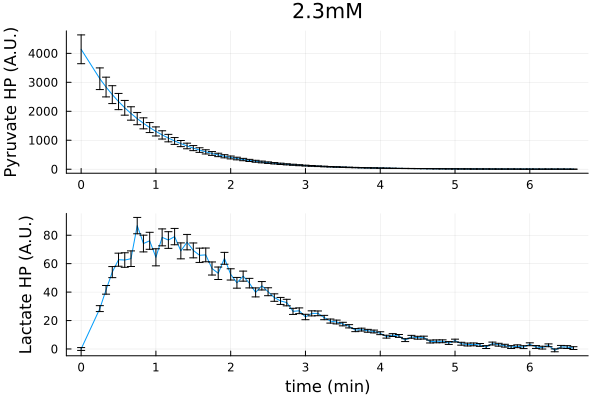

In [99]:
pp1 = plot(samps./60, SolN1NoiseHet[:,1, 1], yerror = basemat[:,1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, SolN1NoiseHet[:,1, 2], yerror = basemat[:,1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

## Generate CSV Files For PseudoData

In [100]:
# Observables
for i in 1:Nexp
    Observables = zeros(length(samps),5);
    Observables[:,1] = samps;
    Observables[:,2] = SolN1NoiseHet[:,i, 1];
    Observables[:,3] = basemat[:,i, 1];
    Observables[:,4] = SolN1NoiseHet[:,i, 2];
    Observables[:,5] = basemat[:,i, 2];
    obs_head = ["time","Pyr_MEAN","Pyr_STD","Lac_MEAN","Lac_STD"];

    df1 = DataFrame(Observables, :auto);
    rename!(df1, [obs_head[i] for i in 1:5]);
    CSV.write(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\CompReprFixedPars_OED2_Observables_Pyr",string(round(inputOED[1], digits = 1)),"mM.csv"), df1);
end

# Bayesian Inference 2

## Extract Data

In [34]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 1;
paths = [mainpath*"CompReprFixedPars_OED1_Observables_Pyr"*string(round(0.6, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED2_Observables_Pyr"*string(round(inputOED[1], digits = 1))*"mM.csv"]

2-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED1_Observables_Pyr0.6mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED2_Observables_Pyr2.3mM.csv"

In [35]:
Random.seed!(8987654);
global dat = restructDatInfCompRep_FixedSF(paths, poster[1,14], 
                                          poster[1,15], 
                                          poster[1,16], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [1080.0 4140.0; 813.677 3123.58; … ; -5.10294 1.5988; -4.95521 1.…
  "stsl"   => [78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0; 15 15; … ; 390 390; 395 395]
  "obser"  => 2
  "Y0us"   => [600.0 2300.0; 0.0 0.0; … ; 0.0 0.0; 1080.0 4140.0]
  "ts"     => [1.0e-20 1.0e-20; 1.0 1.0; … ; 394.0 394.0; 395.0 395.0]
  "itp"    => [0.0, 0.0]
  "ncells" => [0 0]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [129.6 496.8; 97.6413 374.83; … ; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.…
  "m"      => 2
  "nts"    => [395 395]

## Prior Prediction

In [103]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(sampsTh[i,end]*0.12)];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(abs.(poster[i,1:13]), 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [104]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


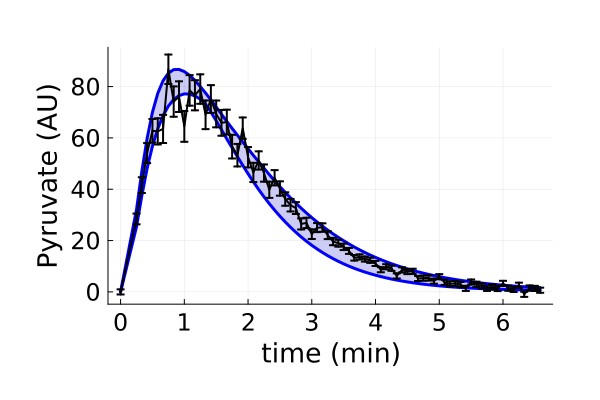

In [105]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

## MLE to obtain a good first guess for inference

In [36]:
dat["Means"]

78×2×2 Array{Float64, 3}:
[:, :, 1] =
 1080.0      4140.0
  813.677    3123.58
  737.279    2836.32
  666.771    2574.41
  601.876    2336.4
  542.284    2120.34
  487.669    1924.24
  437.698    1746.26
  392.043    1584.71
  350.386    1438.08
    ⋮        
   -6.37031     3.58964
   -6.16239     3.21356
   -5.96382     2.87312
   -5.7744      2.56498
   -5.59387     2.2861
   -5.42197     2.03373
   -5.25843     1.80539
   -5.10294     1.5988
   -4.95521     1.41192

[:, :, 2] =
  0.0       0.0
  8.69903  28.4024
 13.4983   41.5869
 19.0213   54.0679
 24.0491   62.7735
 26.0646   62.5501
 28.6646   63.4913
 42.2405   86.7486
 38.7746   74.1541
 42.5445   76.063
  ⋮        
  5.52346   1.30614
  7.40294   3.32314
  5.35751   1.40734
  4.77911   0.951112
  6.30754   2.59468
  2.64823  -0.956139
  5.01913   1.51699
  4.7516    1.34579
  3.94166   0.626616

In [37]:
function ObjectFunctMECp_Multi_MLE(p)

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p[1:end-3], 0);
    obj = 0;
    
    for i in 1:length(dat["stsl"])
        # Define time vector
        t2cor = dat["sts"][:,i];

        # Define equaly-spaced time vector
        ts1 = collect(0:t2cor[end]);

        # Define initial value for simulation (use of experimental mean)
        ivss1 = [dat["Means"][1,i,1]/(ScFm*0.12), 0, dat["Means"][1,i,2]/(ScFm*0.12), p[end-2], p[end-1], p[end], 0, 0, 0, 0, 0, dat["Means"][1,i,1]/(ScFm*0.12), dat["Means"][1,i,2], dat["Means"][1,i,1]];

        # Convert sampling vector to integer to extract correct elements from simulation
        samps1 = convert.(Int, t2cor);

        # Simulate
        SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllCp(ts1, pD2, ivss1, samps1);
    
        mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat["Erros"][:,i,2].^2) .+ ((SimOnTime1[:,13] .- dat["Means"][:,i,2]).^2)./(dat["Erros"][:,i,2].^2)));

        # obj = (mm21+mm22)*(mm11+mm12);
        if p[end-2] >= p[end-1]
            mm22 = mm22*10;
        end
        obj = -(mm22)+obj;
    end
    
    return(obj)

end

ObjectFunctMECp_Multi_MLE (generic function with 1 method)

In [38]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_Multi_MLE(p)

6849.417916880001

In [39]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [110]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_Multi_MLE; SearchRange = vcat([(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 1:13], 
                                                                [(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 14:16]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*2, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 52 evals, 26 steps, improv/step: 0.346 (last = 0.3462), fitness=362.413758990
1.01 secs, 95 evals, 52 steps, improv/step: 0.385 (last = 0.4231), fitness=362.413758990
1.52 secs, 132 evals, 77 steps, improv/step: 0.351 (last = 0.2800), fitness=358.243137850
2.03 secs, 197 evals, 124 steps, improv/step: 0.339 (last = 0.3191), fitness=346.019364192
2.54 secs, 247 evals, 167 steps, improv/step: 0.335 (last = 0.3256), fitness=346.019364192
3.04 secs, 313 evals, 223 steps, improv/step: 0.287 (last = 0.1429), fitness=346.019364192
3.54 secs, 349 evals, 255 steps, improv/step: 0.290 (last = 0.3125), fitness=346.019364192
4.05 secs, 382 evals, 286 steps, improv/step: 0.287 (last = 0.2581), fitness=346.019364192
4.55 secs, 436 evals, 338 steps, improv/step: 0.278 (last = 0.2308), fitn

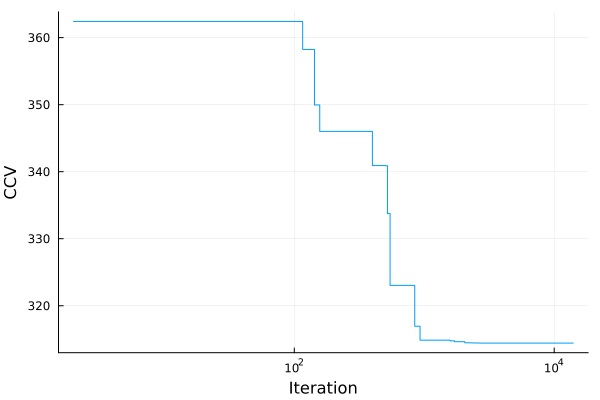

In [111]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [112]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.005751504095260286
     0.018123615595505745
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9521034930089058
     0.001631672540732851
    15.0
   450.0
 12599.0
   226.0

In [113]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_OED2.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED2.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [40]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED2.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.005751504095260286
     0.018123615595505745
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9521034930089058
     0.001631672540732851
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [41]:
preTrans = zeros(13);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [42]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.0914560346401041, "kr" => -0.8747085925980337, "ki" => 0.004428406334538711, "kpl" => -0.6819188657814004)
 Dict("kin" => 0.0914560346401041, "kr" => -0.8747085925980337, "ki" => 0.004428406334538711, "kpl" => -0.6819188657814004)
 Dict("kin" => 0.0914560346401041, "kr" => -0.8747085925980337, "ki" => 0.004428406334538711, "kpl" => -0.6819188657814004)
 Dict("kin" => 0.0914560346401041, "kr" => -0.8747085925980337, "ki" => 0.004428406334538711, "kpl" => -0.6819188657814004)

In [43]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.091456
  "kr"  => -0.874709
  "ki"  => 0.00442841
  "kpl" => -0.681919

## Inference

In [118]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_OED2_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;


File c:\IBECPostDocDrive\2024_01_16_NCvsKR\DataProcessingInference\ComputationalBayesianOED\tmp\PyrCompReprFP_OED2_Try1.stan will be updated.



In [119]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_OED2_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one interna

Inference for Stan model: PyrCompReprFP_OED2_Try1_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(1000,1000,1000,1000); thin=(1,1,1,1); 12000 iterations saved.

Warmup took (9396, 9882, 16377, 8965) seconds, 12 hours total
Sampling took (19016, 17584, 16717, 19245) seconds, 20 hours total

                    Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__            -3.2e+02  2.5e-02  1.4e+00  -3.2e+02  -3.2e+02  -3.2e+02  3.3e+03  4.6e-02  1.0e+00
accept_stat__       0.95  1.1e-03    0.089      0.76      0.98       1.0  6.6e+03  9.1e-02  1.0e+00
stepsize__          0.22  4.1e-03    0.066      0.12      0.22      0.33  2.6e+02  3.6e-03  1.0e+00
treedepth__          3.6  1.1e-02     0.84       2.0       4.0       5.0  5.9e+03  8.1e-02  1.0e+00
n_leapfrog__          16  1.2e-01      9.4       3.0        15        31  5.8e+03  8.0e-02  1.0e+00
divergent__         0.00      nan     0.00      0.00      0.00      0.00      nan      nan    

(0, [-315.596 0.957757 … 12599.0 226.0; -315.596 0.0 … 12599.0 226.0; … ; -316.356 0.934617 … 12599.0 226.0; -315.493 0.992777 … 12599.0 226.0;;; -317.774 0.711252 … 12599.0 226.0; -317.774 0.0 … 12599.0 226.0; … ; -318.022 0.868326 … 12599.0 226.0; -318.528 0.99009 … 12599.0 226.0;;; -315.806 0.933837 … 12599.0 226.0; -315.806 0.0 … 12599.0 226.0; … ; -317.263 0.959801 … 12599.0 226.0; -318.813 0.974034 … 12599.0 226.0;;; -318.507 0.792062 … 12599.0 226.0; -318.507 0.0 … 12599.0 226.0; … ; -318.113 0.726339 … 12599.0 226.0; -316.032 0.994354 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [120]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_OED2_Try2.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [121]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.csv"

In [44]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00580305  0.0182826  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00593753  0.0179379  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00571242  0.0185024  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00578915  0.0177476  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00565094  0.0182107  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00569979  0.0181712  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00576928  0.0182311  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00577227  0.018567   0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00577261  0.0177645  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00577469  0.0177423  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00578355  0.0184259  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00585954  0.0180028  0.042171     15.0

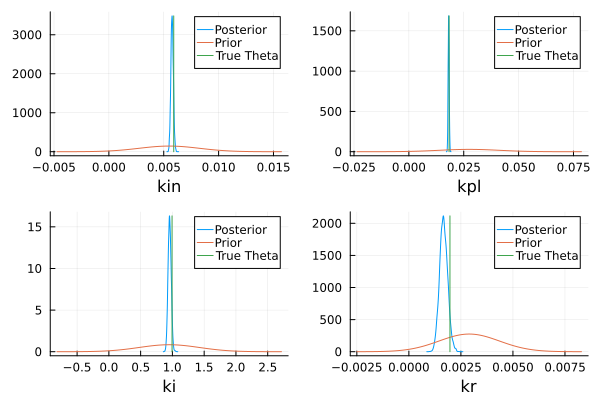

In [46]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

In [146]:
names

4-element Vector{String}:
 "kin"
 "kpl"
 "ki"
 "kr"

In [144]:
mean(poster, dims = 1)

1×16 Matrix{Float64}:
 48.0  55.0  0.00620037  0.0198683  …  15.0  457.089  16041.7  348.181

In [145]:
std(poster, dims = 1)

1×16 Matrix{Float64}:
 0.0  0.0  0.000739554  0.00271774  …  0.0  231.595  6556.18  177.623

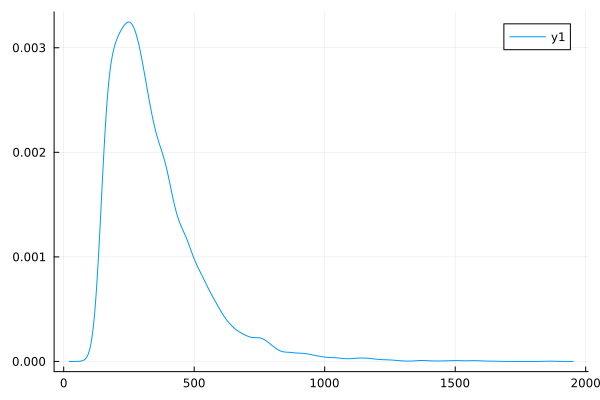

In [146]:
plot(kde(poster[:,16]))

## Simulate Experiment Current Posterior

In [138]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [139]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


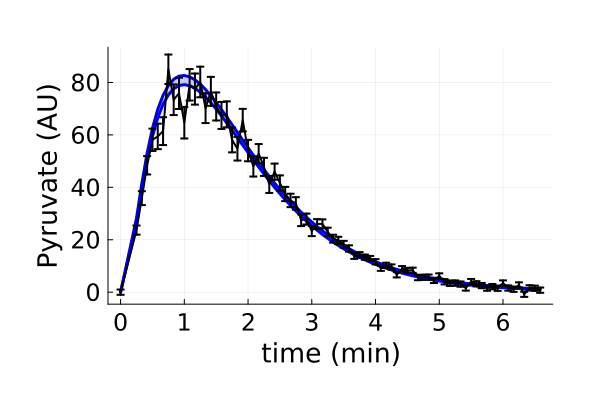

In [140]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

# Perform OEDmc 3

In [164]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global tsC2 = dat32mM[:,1]
global ts = 0:tsC2[end];
global samps = convert.(Int, tsC2);


In [165]:
global sampsTh = abs.(poster[:,1:13]);
global sampsY0 = abs.(poster[:,14:end]);

In [166]:
CompRepUtil_Entro_OEDmc([0.1])

-52.932931847384964

## Optimisation 

In [83]:
steps = 1;

In [84]:
model = ElasticGPE(steps,                            # 4*2 input dimensions
           mean = MeanConst(0.),
           kernel = SEArd(zeros(steps), 3.),
           logNoise = 0.,
           capacity = 3000);

In [85]:
modeloptimizer = MAPGPOptimizer(every = 50, noisebounds = [-4, 3],       # bounds of the logNoise
                               kernbounds = [[-1*ones(steps); 0], [4*ones(steps); 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                               maxeval = 50);

In [86]:
opt = BOpt(CompRepUtil_Entro_OEDmc,
          model,
          ExpectedImprovement(),                   # type of acquisition            UpperConfidenceBound
          modeloptimizer,
          [0.1],[40.], # lowerbounds, upperbounds
          repetitions = 1,                          # evaluate the function for each input 1 times
          maxiterations = 200,                      # evaluate at 50 input positions
          sense = Max,  
                                      # maximise the function
          acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                restarts = 2,       # run the NLopt method from 5 random initial conditions each time.
                maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl
          verbosity = Progress);

In [87]:
result = boptimize!(opt) # 40 min

┌ Info: 2024-08-09T17:50:46.655	iteration: 5	current optimum: -22.081543604782432
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-09T17:50:56.760	iteration: 6	current optimum: -22.081543604782432
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-09T17:51:01.468	iteration: 7	current optimum: -22.081543604782432
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-09T17:51:06.311	iteration: 8	current optimum: -22.081543604782432
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-09T17:51:11.467	iteration: 9	current optimum: -22.081543604782432
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 20

(observed_optimum = 33.52946200365547, observed_optimizer = [0.3513086307621788], model_optimum = 1.56864477015284, model_optimizer = [0.1])

In [149]:
inputOED = result.observed_optimizer

1-element Vector{Float64}:
 0.5444612993758793

In [165]:
# inputOED = 0.5444612993758793;

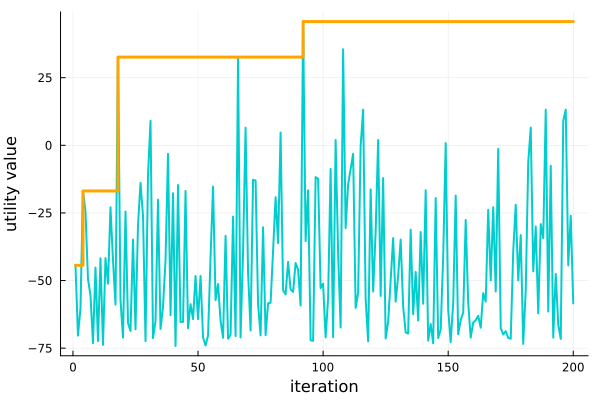

In [150]:
utilb = zeros(length(opt.model.y));
utilb[1] = opt.model.y[1];
for i in 2:length(opt.model.y)
    if opt.model.y[i]>=utilb[i-1]
        utilb[i] = opt.model.y[i];
    else
        utilb[i] = utilb[i-1];
    end
end

plot(opt.model.y, label = "", xlabel = "iteration", ylabel = "utility value", color="cyan3", linewidth = 2)
plot!(1:length(utilb), utilb, label = "", linetype=:step, color="orange", linewidth = 3)

### Save resutls

In [151]:
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED3_OEDmc.jld"), "result", result, "inputOED",inputOED)

In [152]:
optres = Dict("acquisitionoptions"=>opt.acquisitionoptions,
                "duration"=>opt.duration,
#                 "func"=>opt.func,
#                 "initializer"=>opt.initializer,
#                 "iterations"=>opt.iterations,
#                 "iterations"=>opt.iterations,
#                 "lowerbounds"=>opt.lowerbounds,
#                 "model"=>opt.model,
                "model_optimizer"=>opt.model_optimizer,
                "model_optimum"=>opt.model_optimum,
                "modeloptimizer"=>opt.modeloptimizer,
                "observed_optimizer"=>opt.observed_optimizer,
                "observed_optimum"=>opt.observed_optimum,
#                 "opt"=>opt.opt,
                "repetitions"=>opt.repetitions,
                "sense"=>opt.sense,
#                 "timeroutput"=>opt.timeroutput,
                "upperbounds"=>opt.upperbounds,
#                 "verbosity"=>opt.verbosity,
                "modelX"=>Array(opt.model.x),
                "modelY"=>Array(opt.model.y));
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED3_OEDmc2.jld"), optres)

## Generate Pseudo-Data

In [153]:
Nexp = 1;

ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(trueP[end]*0.12)]

SimulsAll = Array{Any}(undef, Nexp,3);
for i in 1:Nexp
    SimulsAll[i,1], SimulsAll[i,2], SimulsAll[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
end
ObsS = Array{Any}(undef, Nexp,2);
for i in 1:Nexp
    ObsS[i,1] = SimulsAll[i,1][:,14,1]; # Pyruvate HP
    ObsS[i,2] = SimulsAll[i,1][:,13,1]; # Lactate HP
end

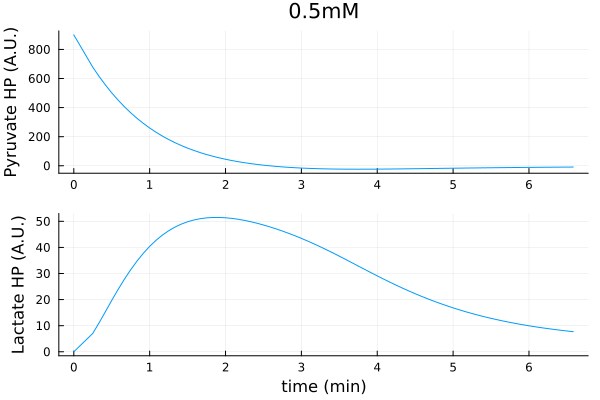

In [154]:
pp1 = plot(samps./60, ObsS[1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, ObsS[1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

In [155]:
sigm1=0.12; # 10% additive heteroscedastic noise
sigm2=0.075;


Random.seed!(45659211); 

SolN1NoiseHet = zeros(length(samps),Nexp,2);
basemat = zeros(length(samps),Nexp,2);

i = 1

for i in 1:Nexp
    basemat[:,i,1] = ObsS[i,1]'.*sigm1; # introduce new diagonal matrices
    basemat[:,i,2] = ObsS[i,2]'.*sigm2;

    for zer in collect(1:length(samps)) # To avoid having standard deviations of 0
        if basemat[zer,i,1]<=1
            basemat[zer,i,1] = 1;
        end
        if basemat[zer,i,2]<=1
            basemat[zer,i,2] = 1;
        end
    end

    SolN1NoiseHet[:,i, 1] = ObsS[i,1]#+rand(MvNormal(zeros(length(samps)),basemat[:,i,1]));
    SolN1NoiseHet[:,i, 2] = ObsS[i,2]+rand(MvNormal(zeros(length(samps)),basemat[:,i,2]));
    SolN1NoiseHet[1,i, 2] = 0;
end

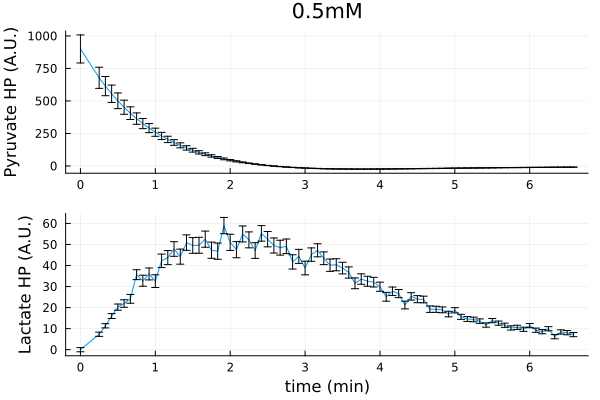

In [156]:
pp1 = plot(samps./60, SolN1NoiseHet[:,1, 1], yerror = basemat[:,1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, SolN1NoiseHet[:,1, 2], yerror = basemat[:,1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

## Generate CSV Files For PseudoData

In [157]:
# Observables
for i in 1:Nexp
    Observables = zeros(length(samps),5);
    Observables[:,1] = samps;
    Observables[:,2] = SolN1NoiseHet[:,i, 1];
    Observables[:,3] = basemat[:,i, 1];
    Observables[:,4] = SolN1NoiseHet[:,i, 2];
    Observables[:,5] = basemat[:,i, 2];
    obs_head = ["time","Pyr_MEAN","Pyr_STD","Lac_MEAN","Lac_STD"];

    df1 = DataFrame(Observables, :auto);
    rename!(df1, [obs_head[i] for i in 1:5]);
    CSV.write(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\CompReprFixedPars_OED3_Observables_Pyr",string(round(inputOED[1], digits = 1)),"mM.csv"), df1);
end

# Bayesian Inference 3

## Extract Data

In [158]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 1;
paths = [mainpath*"CompReprFixedPars_OED1_Observables_Pyr"*string(round(0.6, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED2_Observables_Pyr"*string(round(2.3, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED3_Observables_Pyr"*string(round(inputOED[1], digits = 1))*"mM.csv"]

3-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED1_Observables_Pyr0.6mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED2_Observables_Pyr2.3mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED3_Observables_Pyr0.5mM.csv"

In [160]:
Random.seed!(8987654);
global dat = restructDatInfCompRep_FixedSF(paths, poster[1,14], 
                                          poster[1,15], 
                                          poster[1,16], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [1080.0 4140.0 900.0; 813.677 3123.58 678.033; … ; -5.10294 1.598…
  "stsl"   => [78 78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0 0; 15 15 15; … ; 390 390 390; 395 395 395]
  "obser"  => 2
  "Y0us"   => [600.0 2300.0 500.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 1080.0 4140.0 …
  "ts"     => [1.0e-20 1.0e-20 1.0e-20; 1.0 1.0 1.0; … ; 394.0 394.0 394.0; 395…
  "itp"    => [0.0, 0.0, 0.0]
  "ncells" => [0 0 0]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [129.6 496.8 108.0; 97.6413 374.83 81.364; … ; 1.0 1.0 1.0; 1.0 1…
  "m"      => 3
  "nts"    => [395 395 395]

## Prior Prediction

In [161]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(sampsTh[i,end]*0.12)];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(abs.(poster[i,1:13]), 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [162]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


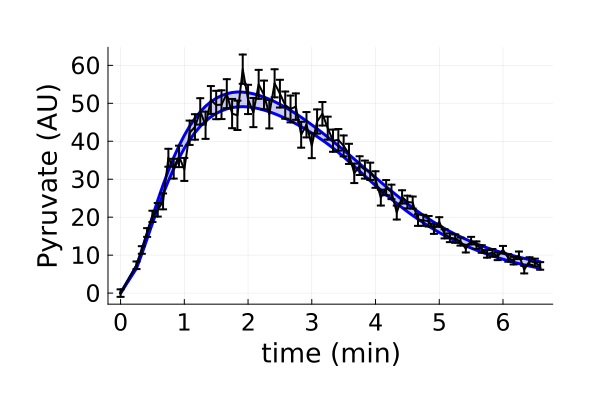

In [163]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

## MLE to obtain a good first guess for inference

In [164]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_Multi_MLE(p)

11391.000499013186

In [165]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [166]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_Multi_MLE; SearchRange = vcat([(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 1:13], 
                                                                [(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 14:16]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*2, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.54 secs, 30 evals, 16 steps, improv/step: 0.438 (last = 0.4375), fitness=487.214758936
1.04 secs, 60 evals, 33 steps, improv/step: 0.455 (last = 0.4706), fitness=481.765182392
1.57 secs, 94 evals, 53 steps, improv/step: 0.358 (last = 0.2000), fitness=481.765182392
2.09 secs, 132 evals, 79 steps, improv/step: 0.367 (last = 0.3846), fitness=478.847382888
2.61 secs, 161 evals, 97 steps, improv/step: 0.340 (last = 0.2222), fitness=478.847382888
3.12 secs, 197 evals, 121 steps, improv/step: 0.347 (last = 0.3750), fitness=477.746259574
3.62 secs, 233 evals, 152 steps, improv/step: 0.336 (last = 0.2903), fitness=477.746259574
4.15 secs, 262 evals, 173 steps, improv/step: 0.341 (last = 0.3810), fitness=477.746259574
4.67 secs, 302 evals, 209 steps, improv/step: 0.330 (last = 0.2778), fitness

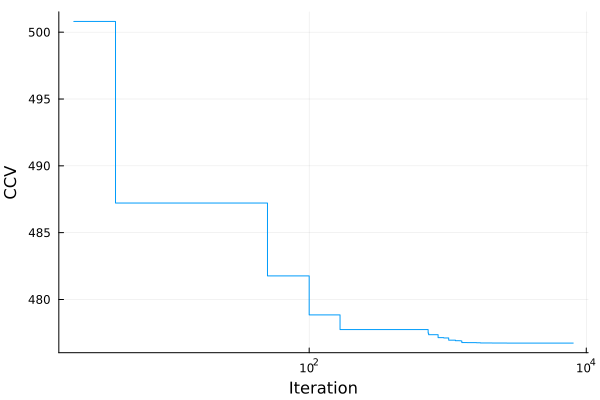

In [167]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [168]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.005775731824912721
     0.018140315612288852
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9471158067721605
     0.0016364453731599674
    15.0
   450.0
 12599.0
   226.0

In [169]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_OED3.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED3.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [170]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED3.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.005775731824912721
     0.018140315612288852
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9471158067721605
     0.0016364453731599674
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [171]:
preTrans = zeros(4);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [172]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.10026611815008038, "kr" => -0.8714169840276086, "ki" => -0.00607198574282001, "kpl" => -0.6807043191062653)
 Dict("kin" => 0.10026611815008038, "kr" => -0.8714169840276086, "ki" => -0.00607198574282001, "kpl" => -0.6807043191062653)
 Dict("kin" => 0.10026611815008038, "kr" => -0.8714169840276086, "ki" => -0.00607198574282001, "kpl" => -0.6807043191062653)
 Dict("kin" => 0.10026611815008038, "kr" => -0.8714169840276086, "ki" => -0.00607198574282001, "kpl" => -0.6807043191062653)

In [173]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.100266
  "kr"  => -0.871417
  "ki"  => -0.00607199
  "kpl" => -0.680704

## Inference

In [175]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_OED3_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;

In [176]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_OED3_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Inference for Stan model: PyrCompReprFP_OED3_Try1_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(1000,1000,1000,1000); thin=(1,1,1,1); 12000 iterations saved.

Warmup took (18719, 17704, 17370, 17229) seconds, 20 hours total
Sampling took (28011, 25822, 25423, 26805) seconds, 29 hours total

                    Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__            -4.8e+02  2.6e-02  1.4e+00  -4.8e+02  -4.8e+02  -4.8e+02  3.1e+03  2.9e-02  1.0e+00
accept_stat__       0.95  1.0e-03    0.089      0.77      0.98      1.00  7.7e+03  7.2e-02  1.0e+00
stepsize__          0.17  7.0e-03    0.051     0.095      0.17      0.26  5.3e+01  5.0e-04  1.0e+00
treedepth__          3.8  1.2e-02     0.92       2.0       4.0       5.0  5.9e+03  5.6e-02  1.0e+00
n_leapfrog__          21  1.9e-01       13       7.0        15        47  4.7e+03  4.4e-02  1.0e+00
divergent__         0.00      nan     0.00      0.00      0.00      0.00      nan      nan 

(0, [-478.195 0.979034 … 12599.0 226.0; -478.195 0.0 … 12599.0 226.0; … ; -478.313 0.892018 … 12599.0 226.0; -478.848 0.951955 … 12599.0 226.0;;; -477.379 0.988977 … 12599.0 226.0; -477.379 0.0 … 12599.0 226.0; … ; -478.316 0.993251 … 12599.0 226.0; -478.488 0.714998 … 12599.0 226.0;;; -478.306 0.727475 … 12599.0 226.0; -478.306 0.0 … 12599.0 226.0; … ; -479.942 0.983219 … 12599.0 226.0; -478.376 0.985326 … 12599.0 226.0;;; -478.482 0.176934 … 12599.0 226.0; -478.482 0.0 … 12599.0 226.0; … ; -477.984 1.0 … 12599.0 226.0; -479.345 0.783262 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [177]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_OED3_Try2.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [178]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.csv"

In [47]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00591324  0.0177228  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00589272  0.0176773  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00587361  0.0174306  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00587142  0.0175547  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00584043  0.0185057  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00582324  0.0185117  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00577057  0.0178088  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00587842  0.0183401  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00583173  0.0182346  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00584215  0.0182384  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00582348  0.0177766  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00593692  0.0182977  0.042171     15.0

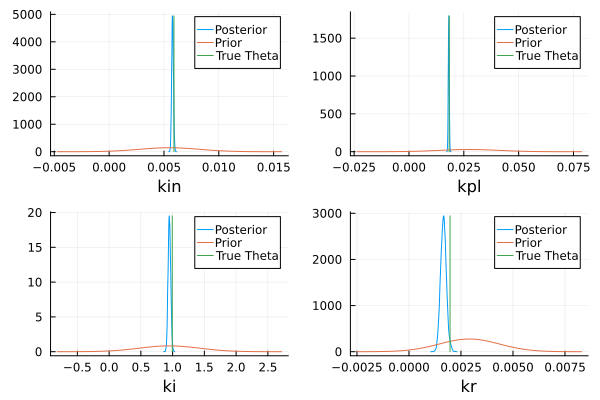

In [48]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [49]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [50]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


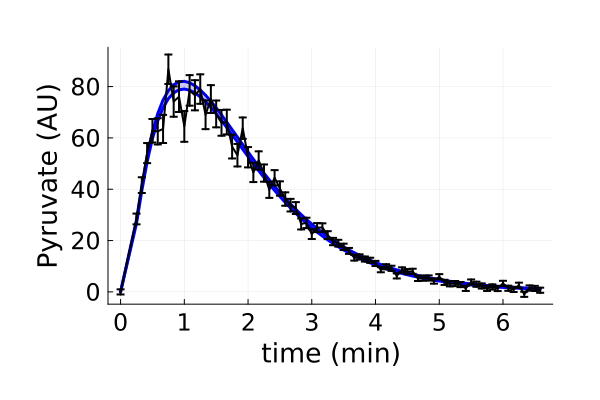

In [51]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

# Posterior Checks

In [98]:
posterO1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.csv", DataFrame));
posterR1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.csv", DataFrame));
posterI1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID1_Try1.csv", DataFrame));

posterO2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.csv", DataFrame));
posterR2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.csv", DataFrame));
posterI2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID2_Try1.csv", DataFrame));

posterO3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.csv", DataFrame));
posterR3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.csv", DataFrame));
posterI3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID3_Try1.csv", DataFrame));

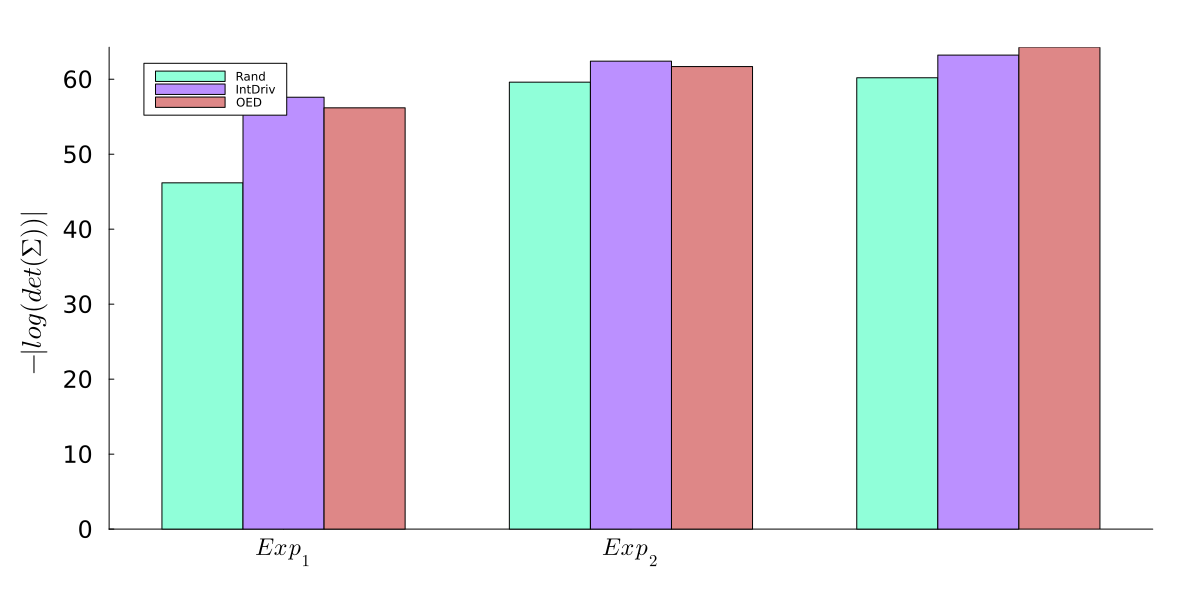

In [99]:
cvO = [-log(det(cov(hcat(posterO1[:,3:4], posterO1[:,11:12])))), -log(det(cov(hcat(posterO2[:,3:4], posterO2[:,11:12])))), -log(det(cov(hcat(posterO3[:,3:4], posterO3[:,11:12]))))];
cvR = [-log(det(cov(hcat(posterR1[:,3:4], posterR1[:,11:12])))), -log(det(cov(hcat(posterR2[:,3:4], posterR2[:,11:12])))), -log(det(cov(hcat(posterR3[:,3:4], posterR3[:,11:12]))))];
cvI = [-log(det(cov(hcat(posterI1[:,3:4], posterI1[:,11:12])))), -log(det(cov(hcat(posterI2[:,3:4], posterI2[:,11:12])))), -log(det(cov(hcat(posterI3[:,3:4], posterI3[:,11:12]))))];

groupedbar(abs.([cvR cvI cvO]) , bar_position = :dodge, bar_width=0.7, label = ["Rand" "IntDriv" "OED"], colour = ["#90ffd9ff" "#bb90ffff" "#de8787ff"], xticks = (1:2, [L"Exp_1", L"Exp_2"]), 
        ylabel = L"-|log(det(\Sigma))|", margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
        size = (1200,600), grid = false)

# Perform OEDmc 4

In [52]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global tsC2 = dat32mM[:,1]
global ts = 0:tsC2[end];
global samps = convert.(Int, tsC2);


In [53]:
global sampsTh = abs.(poster[:,1:13]);
global sampsY0 = abs.(poster[:,14:end]);

In [54]:
CompRepUtil_Entro_OEDmc([0.1])

-73.88536851405308

## Optimisation 

In [55]:
steps = 1;

In [56]:
model = ElasticGPE(steps,                            # 4*2 input dimensions
           mean = MeanConst(0.),
           kernel = SEArd(zeros(steps), 3.),
           logNoise = 0.,
           capacity = 3000);

In [57]:
modeloptimizer = MAPGPOptimizer(every = 50, noisebounds = [-4, 3],       # bounds of the logNoise
                               kernbounds = [[-1*ones(steps); 0], [4*ones(steps); 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                               maxeval = 50);

In [58]:
opt = BOpt(CompRepUtil_Entro_OEDmc,
          model,
          ExpectedImprovement(),                   # type of acquisition            UpperConfidenceBound
          modeloptimizer,
          [0.1],[40.], # lowerbounds, upperbounds
          repetitions = 1,                          # evaluate the function for each input 1 times
          maxiterations = 200,                      # evaluate at 50 input positions
          sense = Max,  
                                      # maximise the function
          acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                restarts = 2,       # run the NLopt method from 5 random initial conditions each time.
                maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl
          verbosity = Progress);

In [59]:
result = boptimize!(opt) # 40 min

┌ Info: 2024-08-14T16:20:35.719	iteration: 5	current optimum: -26.378468343780277
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-14T16:20:43.289	iteration: 6	current optimum: -26.378468343780277
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-14T16:20:44.953	iteration: 7	current optimum: -26.378468343780277
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-14T16:20:48.640	iteration: 8	current optimum: -26.378468343780277
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 2024-08-14T16:20:52.349	iteration: 9	current optimum: -26.378468343780277
└ @ BayesianOptimization C:\Users\dgomez\.julia\packages\BayesianOptimization\nq1HY\src\BayesianOptimization.jl:140
┌ Info: 20

(observed_optimum = 15.700093454757592, observed_optimizer = [0.41157642513207177], model_optimum = -15.363337682262774, model_optimizer = [2.323083537262346])

In [66]:
inputOED = result.observed_optimizer

1-element Vector{Float64}:
 0.41157642513207177

In [137]:
# inputOED = 0.4272864930716401;

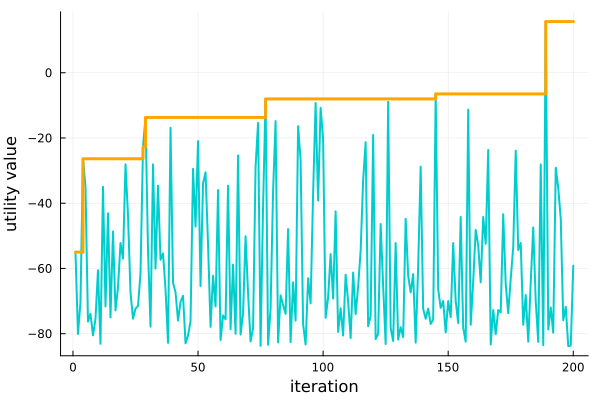

In [67]:
utilb = zeros(length(opt.model.y));
utilb[1] = opt.model.y[1];
for i in 2:length(opt.model.y)
    if opt.model.y[i]>=utilb[i-1]
        utilb[i] = opt.model.y[i];
    else
        utilb[i] = utilb[i-1];
    end
end

plot(opt.model.y, label = "", xlabel = "iteration", ylabel = "utility value", color="cyan3", linewidth = 2)
plot!(1:length(utilb), utilb, label = "", linetype=:step, color="orange", linewidth = 3)

### Save resutls

In [68]:
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED4_OEDmc.jld"), "result", result, "inputOED",inputOED)

In [69]:
optres = Dict("acquisitionoptions"=>opt.acquisitionoptions,
                "duration"=>opt.duration,
#                 "func"=>opt.func,
#                 "initializer"=>opt.initializer,
#                 "iterations"=>opt.iterations,
#                 "iterations"=>opt.iterations,
#                 "lowerbounds"=>opt.lowerbounds,
#                 "model"=>opt.model,
                "model_optimizer"=>opt.model_optimizer,
                "model_optimum"=>opt.model_optimum,
                "modeloptimizer"=>opt.modeloptimizer,
                "observed_optimizer"=>opt.observed_optimizer,
                "observed_optimum"=>opt.observed_optimum,
#                 "opt"=>opt.opt,
                "repetitions"=>opt.repetitions,
                "sense"=>opt.sense,
#                 "timeroutput"=>opt.timeroutput,
                "upperbounds"=>opt.upperbounds,
#                 "verbosity"=>opt.verbosity,
                "modelX"=>Array(opt.model.x),
                "modelY"=>Array(opt.model.y));
JLD2.save(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\OptimisationResults_Seq\\CRFP_SeqOED_OED4_OEDmc2.jld"), optres)

## Generate Pseudo-Data

In [70]:
Nexp = 1;

ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(trueP[end]*0.12)]

SimulsAll = Array{Any}(undef, Nexp,3);
for i in 1:Nexp
    SimulsAll[i,1], SimulsAll[i,2], SimulsAll[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
end
ObsS = Array{Any}(undef, Nexp,2);
for i in 1:Nexp
    ObsS[i,1] = SimulsAll[i,1][:,14,1]; # Pyruvate HP
    ObsS[i,2] = SimulsAll[i,1][:,13,1]; # Lactate HP
end

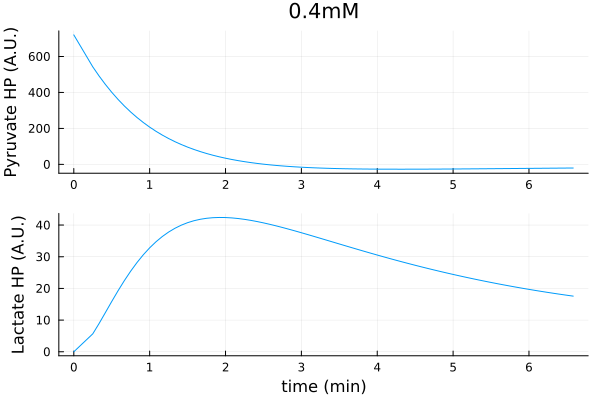

In [71]:
pp1 = plot(samps./60, ObsS[1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, ObsS[1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

In [72]:
sigm1=0.12; # 10% additive heteroscedastic noise
sigm2=0.075;


Random.seed!(45659211); 

SolN1NoiseHet = zeros(length(samps),Nexp,2);
basemat = zeros(length(samps),Nexp,2);

i = 1

for i in 1:Nexp
    basemat[:,i,1] = ObsS[i,1]'.*sigm1; # introduce new diagonal matrices
    basemat[:,i,2] = ObsS[i,2]'.*sigm2;

    for zer in collect(1:length(samps)) # To avoid having standard deviations of 0
        if basemat[zer,i,1]<=1
            basemat[zer,i,1] = 1;
        end
        if basemat[zer,i,2]<=1
            basemat[zer,i,2] = 1;
        end
    end

    SolN1NoiseHet[:,i, 1] = ObsS[i,1]#+rand(MvNormal(zeros(length(samps)),basemat[:,i,1]));
    SolN1NoiseHet[:,i, 2] = ObsS[i,2]+rand(MvNormal(zeros(length(samps)),basemat[:,i,2]));
    SolN1NoiseHet[1,i, 2] = 0;
end

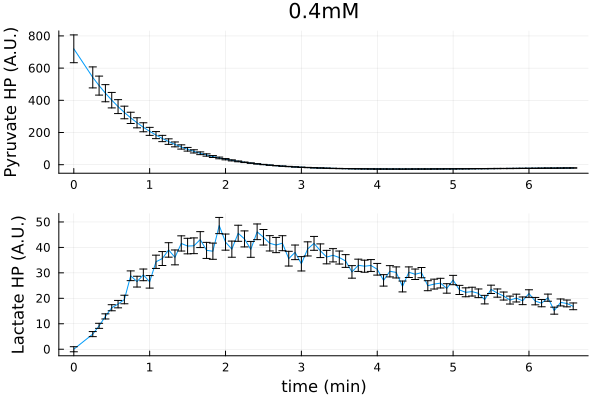

In [73]:
pp1 = plot(samps./60, SolN1NoiseHet[:,1, 1], yerror = basemat[:,1,1], label = "", title = string(round(inputOED[1], digits = 1))*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, SolN1NoiseHet[:,1, 2], yerror = basemat[:,1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

## Generate CSV Files For PseudoData

In [74]:
# Observables
for i in 1:Nexp
    Observables = zeros(length(samps),5);
    Observables[:,1] = samps;
    Observables[:,2] = SolN1NoiseHet[:,i, 1];
    Observables[:,3] = basemat[:,i, 1];
    Observables[:,4] = SolN1NoiseHet[:,i, 2];
    Observables[:,5] = basemat[:,i, 2];
    obs_head = ["time","Pyr_MEAN","Pyr_STD","Lac_MEAN","Lac_STD"];

    df1 = DataFrame(Observables, :auto);
    rename!(df1, [obs_head[i] for i in 1:5]);
    CSV.write(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\CompReprFixedPars_OED4_Observables_Pyr",string(round(inputOED[1], digits = 1)),"mM.csv"), df1);
end

# Bayesian Inference 4

## Extract Data

In [75]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 1;
paths = [mainpath*"CompReprFixedPars_OED1_Observables_Pyr"*string(round(0.6, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED2_Observables_Pyr"*string(round(2.3, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED3_Observables_Pyr"*string(round(0.5, digits = 1))*"mM.csv",
         mainpath*"CompReprFixedPars_OED4_Observables_Pyr"*string(round(inputOED[1], digits = 1))*"mM.csv"]

4-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED1_Observables_Pyr0.6mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED2_Observables_Pyr2.3mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED3_Observables_Pyr0.5mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_OED4_Observables_Pyr0.4mM.csv"

In [76]:
Random.seed!(8987654);
global dat = restructDatInfCompRep_FixedSF(paths, poster[1,14], 
                                          poster[1,15], 
                                          poster[1,16], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [1080.0 4140.0 900.0 720.0; 813.677 3123.58 678.033 542.402; … ; …
  "stsl"   => [78 78 78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0 0 0; 15 15 15 15; … ; 390 390 390 390; 395 395 395 395]
  "obser"  => 2
  "Y0us"   => [600.0 2300.0 500.0 400.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; …
  "ts"     => [1.0e-20 1.0e-20 1.0e-20 1.0e-20; 1.0 1.0 1.0 1.0; … ; 394.0 394.…
  "itp"    => [0.0, 0.0, 0.0, 0.0]
  "ncells" => [0 0 0 0]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [129.6 496.8 108.0 86.4; 97.6413 374.83 81.364 65.0883; … ; 1.0 1…
  "m"      => 4
  "nts"    => [395 395 395 395]

## Prior Prediction

In [77]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [round(inputOED[1], digits = 1)*1000, 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, round(inputOED[1], digits = 1)*1000, 0, round(inputOED[1], digits = 1)*1000*(sampsTh[i,end]*0.12)];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(abs.(poster[i,1:13]), 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [78]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


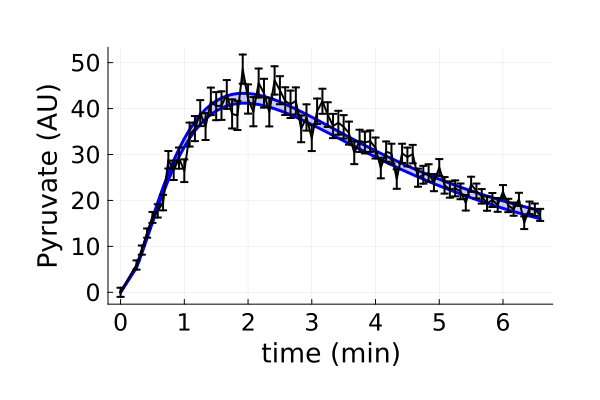

In [79]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

## MLE to obtain a good first guess for inference

In [80]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_Multi_MLE(p)

16271.853552224093

In [81]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [82]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_Multi_MLE; SearchRange = vcat([(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 1:13], 
                                                                [(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 14:16]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*3, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 20 evals, 10 steps, improv/step: 0.500 (last = 0.5000), fitness=657.069664657
1.03 secs, 48 evals, 26 steps, improv/step: 0.423 (last = 0.3750), fitness=648.945825850
1.54 secs, 77 evals, 43 steps, improv/step: 0.465 (last = 0.5294), fitness=648.945825850
2.05 secs, 106 evals, 60 steps, improv/step: 0.417 (last = 0.2941), fitness=648.350412996
2.57 secs, 138 evals, 82 steps, improv/step: 0.366 (last = 0.2273), fitness=648.350412996
3.09 secs, 168 evals, 105 steps, improv/step: 0.371 (last = 0.3913), fitness=648.350412996
3.63 secs, 196 evals, 129 steps, improv/step: 0.333 (last = 0.1667), fitness=648.350412996
4.15 secs, 228 evals, 151 steps, improv/step: 0.331 (last = 0.3182), fitness=648.350412996
4.74 secs, 257 evals, 174 steps, improv/step: 0.333 (last = 0.3478), fitness

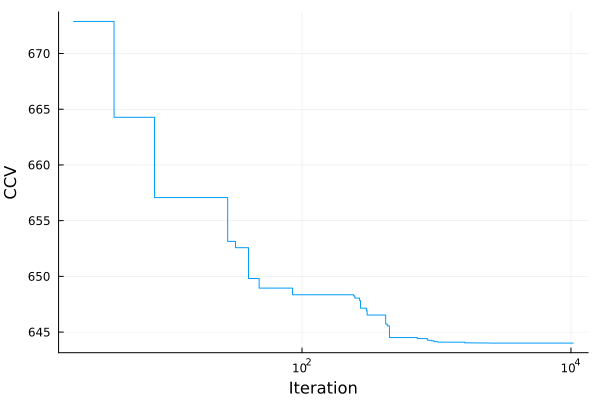

In [83]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [84]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.005844317903120158
     0.018104814550750428
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9537986069302016
     0.001763581967037196
    15.0
   450.0
 12599.0
   226.0

In [85]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_OED4.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED4.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [86]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_OED4.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.005844317903120158
     0.018104814550750428
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9537986069302016
     0.001763581967037196
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [90]:
preTrans = zeros(4);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;


In [91]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.12520651022551227, "kr" => -0.7837365744571062, "ki" => 0.007997067221477095, "kpl" => -0.683286214490878)
 Dict("kin" => 0.12520651022551227, "kr" => -0.7837365744571062, "ki" => 0.007997067221477095, "kpl" => -0.683286214490878)
 Dict("kin" => 0.12520651022551227, "kr" => -0.7837365744571062, "ki" => 0.007997067221477095, "kpl" => -0.683286214490878)
 Dict("kin" => 0.12520651022551227, "kr" => -0.7837365744571062, "ki" => 0.007997067221477095, "kpl" => -0.683286214490878)

In [89]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.125207
  "kr"  => -0.783737
  "ki"  => 0.00799707
  "kpl" => -0.683286

## Inference

In [92]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_OED4_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);

# StanModel = Stanmodel(name="PyrCompReprFP_OED4_TEST1", model=Model, nchains =4,
#             num_samples  = 1000, num_warmup = 200, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;


File c:\IBECPostDocDrive\2024_01_16_NCvsKR\DataProcessingInference\ComputationalBayesianOED\tmp\PyrCompReprFP_OED4_Try1.stan will be updated.



In [93]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_OED4_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one interna

Inference for Stan model: PyrCompReprFP_OED4_Try1_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(1000,1000,1000,1000); thin=(1,1,1,1); 12000 iterations saved.

Warmup took (21357, 23145, 20780, 21767) seconds, 24 hours total
Sampling took (36021, 31675, 35031, 33731) seconds, 38 hours total

                    Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__            -6.5e+02  2.7e-02  1.4e+00  -6.5e+02  -6.5e+02  -6.4e+02  2.8e+03  2.1e-02  1.0e+00
accept_stat__       0.92  1.5e-03     0.12      0.65      0.98       1.0  6.1e+03  4.5e-02  1.0e+00
stepsize__          0.23  2.0e-02    0.071      0.12      0.23      0.35  1.3e+01  9.7e-05  1.1e+00
treedepth__          3.5  1.1e-02     0.88       2.0       4.0       5.0  6.3e+03  4.6e-02  1.0e+00
n_leapfrog__          16  1.3e-01       10       3.0        15        31  6.2e+03  4.5e-02  1.0e+00
divergent__         0.00      nan     0.00      0.00      0.00      0.00      nan      nan 

(0, [-647.773 0.976019 … 12599.0 226.0; -647.773 0.0 … 12599.0 226.0; … ; -650.909 0.792792 … 12599.0 226.0; -649.128 0.989789 … 12599.0 226.0;;; -645.979 0.964449 … 12599.0 226.0; -645.979 0.0 … 12599.0 226.0; … ; -646.416 0.897899 … 12599.0 226.0; -646.214 0.99662 … 12599.0 226.0;;; -645.252 0.866658 … 12599.0 226.0; -645.252 0.0 … 12599.0 226.0; … ; -646.867 1.0 … 12599.0 226.0; -646.649 0.99886 … 12599.0 226.0;;; -644.915 0.994161 … 12599.0 226.0; -644.915 0.0 … 12599.0 226.0; … ; -646.127 0.994899 … 12599.0 226.0; -645.941 0.994575 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [94]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_OED4_Try1.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [95]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED4_Try1.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED4_Try1.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED4_Try1.csv"

In [96]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED4_Try1.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00583284  0.0183142  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00583124  0.0183494  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00580431  0.0180293  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00580456  0.0181348  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00589361  0.0181398  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00587259  0.0180413  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00581101  0.0180438  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.0058024   0.0181702  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00575891  0.0179988  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00576012  0.0180192  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00594168  0.0181015  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00587283  0.0180385  0.042171     15.0

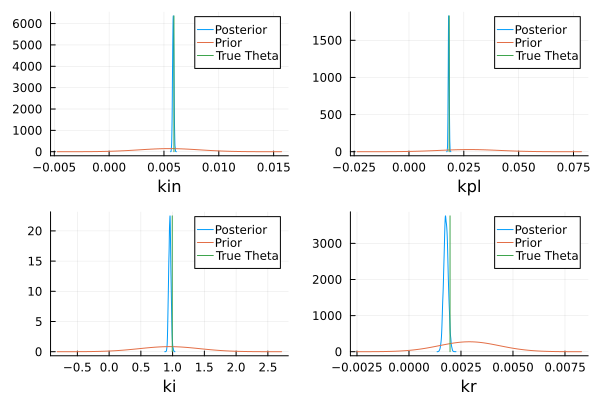

In [97]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [ ]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,1,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [ ]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


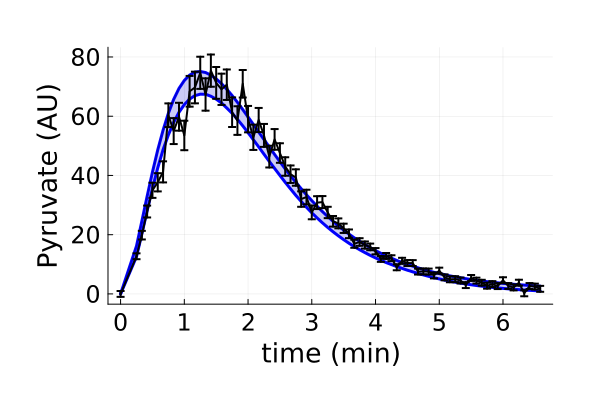

In [ ]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")